<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados Brasil
**Dados crus**: https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time_changesOnly.csv    
**Github**: https://github.com/covidba/covid

In [0]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
 
#!cd gdrive/My\ Drive && rm -r model
#!cd gdrive/My\ Drive && git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model --depth=1
#!pip install platypus-opt
#!pip install pyswarms==1.1.0
 
#add the path were the models are
sys.path.append("/content/gdrive/My Drive/model/main/")
sys.path.append("/content/gdrive/My Drive/model/covid_19")
 
#from modelos import SIR, SEIR

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import _pickle as pk
import datetime as dt
import pandas as pd
import numpy as np

import os
# insert at 1, 0 is the script path (or '' in REPL)
base_dir = '/'.join(os.getcwd().split('/')[:-1])
sys.path.insert(0, base_dir)
from covid19.estimation import ReproductionNumber
#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter
from copy import deepcopy


 
data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time_changesOnly.csv'

df = pd.read_csv(url, usecols=['date', 'country', 'state', 'city', 'ibgeID', 'newDeaths', 'deaths', 'newCases', 'totalCases', 'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', '_source']) #, parse_dates=['data'])
#df.columns = ['data', 'País', 'Estado', 'Cidade', 'IBGE ID', 'Novos mortos', 'Total de Mortos', 'Novos casos', 'Total de casos', 'Mortos por 100k habitantes', 'Total de casos por 100k habitantes', 'Mortos por total de casos', 'Fonte']
df['date'] = pd.to_datetime(df['date'])

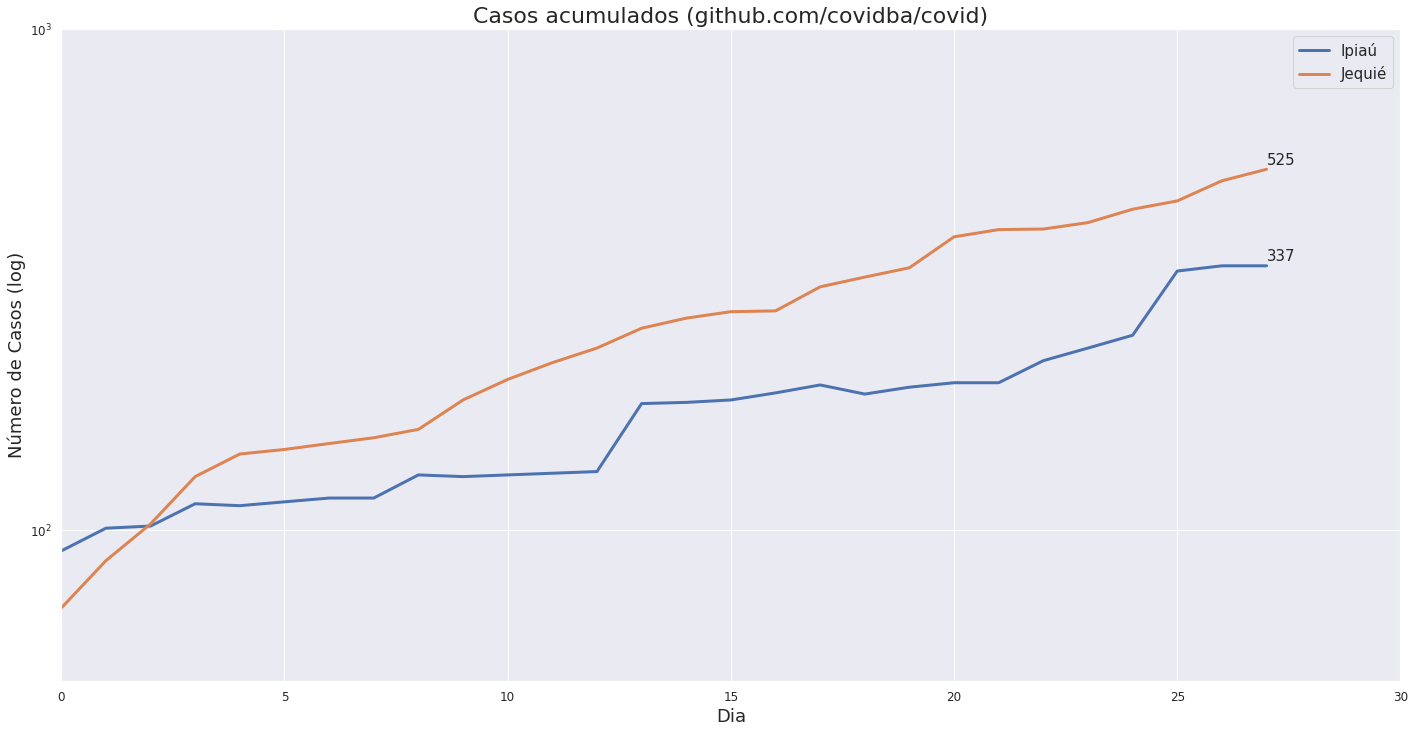

In [0]:
url_fonte = 'github.com/covidba/covid'

from matplotlib.dates import MO
import seaborn as sns
sns.set()

lista_de_cidades = ['Aiquara/BA', 'Apuarema/BA', 'Barra do Rocha/BA', 'Boa Nova/BA', 'Cravolândia/BA', 
                    'Dário Meira/BA', 'Ibirataia/BA', 'Ipiaú/BA', 'Iramaia/BA', 'Itagi/BA', 'Itagibá/BA',
                    'Jaguaquara/BA', 'Jequié/BA', 'Jitaúna/BA', 'Lafaiete Coutinho/BA', 'Lajedo do Tabocal/BA', 'Manoel Vitorino/BA', 'Maracás/BA',
                    'Nova Itarana/BA', 'Santa Inês/BA']

dfx = df.loc[df['city'].isin(lista_de_cidades), ['date', 'city', 'totalCases']]
dfx.columns = ['data', 'Cidade', 'Total de casos']


lista_de_dfx = []
for cidade in lista_de_cidades:
  lista_de_dfx.append(dfx.loc[df['city'].isin([cidade])])

lista_df = []
lista_de_cidades_sem_BA = []
for cidade in lista_de_cidades:
  lista_de_cidades_sem_BA.append(cidade[:-3])

for id, cidade in enumerate(lista_de_cidades_sem_BA):
  df_ = pd.DataFrame({cidade: lista_de_dfx[id]['Total de casos']})
  #df_ = pd.DataFrame({'Data': lista_de_dfx[id]['data'], cidade: lista_de_dfx[id]['Total de casos']})
  lista_df.append(df_)

#refazer lista com casos >= 50
lista_50 = []
for id, lista in enumerate(lista_df):
  lista_ = lista.loc[lista[lista_de_cidades_sem_BA[id]]>=50]
  if not lista_.empty:
    lista_.index = np.arange(len(lista_))
    lista_50.append(lista_)

#for df_geral in lista_50:
  #print(df_geral.index)
  #df_geral.set_index(df_geral.index, inplace=True)
  #df_geral.reset_index(level=, inplace = True) 

#print(df_geral)
df_geral = pd.concat(lista_50, axis=1)
df_geral = df_geral.fillna(method='ffill')

fig, ax = plt.subplots(figsize=(24, 12))
df_geral.plot(ax=ax, kind='line', lw=3)
 
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def adicionar_valores(cidade, id, x=0, y=5):
  if df_geral[cidade].max() >= 50:
    ax.annotate(int(df_geral[cidade].max()), xy=(len(df_geral[cidade])-1, df_geral[cidade].max()), 
                xycoords='data', ha='left', fontsize=15, xytext=(x, y), textcoords='offset points')

for id, cidade in enumerate(df_geral):
  adicionar_valores(cidade, id)

#ax.set_xlim([pd.Timestamp("2020-04-20"), lista_de_dfx[0]['data'].max()]) 
#ax.set_ylim([1, df_geral['Jequié'].max()+10000])
ax.set_ylim([50, 1000])
ax.set_xlim([0, 30]) 
ax.set_title("Casos acumulados (%s)" % url_fonte, fontsize=22)
ax.set_ylabel('Número de Casos (log)', fontsize=18)
ax.set_xlabel('Dia', fontsize=18)
ax.set_yscale('log')
ax.grid(True)

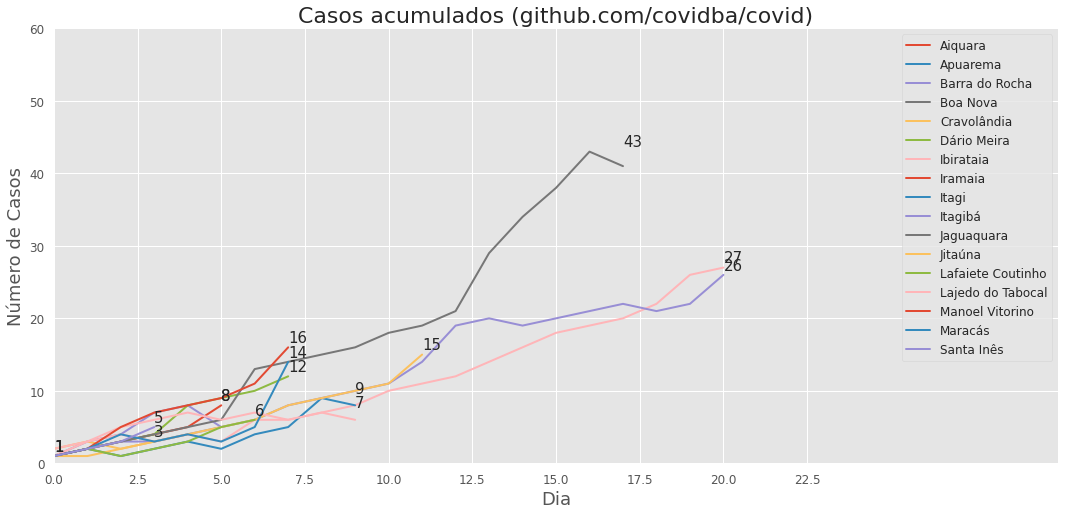

In [135]:
lista_de_cidades = ['Aiquara/BA', 'Apuarema/BA', 'Barra do Rocha/BA', 'Boa Nova/BA', 'Cravolândia/BA', 
                    'Dário Meira/BA', 'Ibirataia/BA', 'Ipiaú/BA', 'Iramaia/BA', 'Itagi/BA', 'Itagibá/BA',
                    'Jaguaquara/BA', 'Jequié/BA', 'Jitaúna/BA', 'Lafaiete Coutinho/BA', 'Lajedo do Tabocal/BA', 'Manoel Vitorino/BA', 'Maracás/BA',
                    'Nova Itarana/BA', 'Santa Inês/BA']

lista_de_cidades.remove('Ipiaú/BA')
lista_de_cidades.remove('Jequié/BA')

dfx = df.loc[df['city'].isin(lista_de_cidades), ['date', 'city', 'totalCases']]
dfx.columns = ['data', 'Cidade', 'Total de casos']


lista_de_dfx = []
for cidade in lista_de_cidades:
  lista_de_dfx.append(dfx.loc[df['city'].isin([cidade])])

lista_df = []
lista_de_cidades_sem_BA = []
for cidade in lista_de_cidades:
  lista_de_cidades_sem_BA.append(cidade[:-3])

for id, cidade in enumerate(lista_de_cidades_sem_BA):
  df_ = pd.DataFrame({cidade: lista_de_dfx[id]['Total de casos']})
  #df_ = pd.DataFrame({'Data': lista_de_dfx[id]['data'], cidade: lista_de_dfx[id]['Total de casos']})
  lista_df.append(df_)

#refazer lista com casos >= 50
lista_50 = []
for id, lista in enumerate(lista_df):
  lista_ = lista.loc[lista[lista_de_cidades_sem_BA[id]]>=0]
  if not lista_.empty:
    lista_.index = np.arange(len(lista_))
    lista_50.append(lista_)

#for df_geral in lista_50:
  #print(df_geral.index)
  #df_geral.set_index(df_geral.index, inplace=True)
  #df_geral.reset_index(level=, inplace = True) 

#print(df_geral)
df_geral = pd.concat(lista_50, axis=1)
#df_geral = df_geral.fillna(method='ffill')

fig, ax = plt.subplots(figsize=(18, 8))
df_geral.plot(ax=ax, kind='line', lw=2)
 
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=12))

def adicionar_valores(cidade, id, x=0, y=5):
  if df_geral[cidade].max() >= 0:
    ax.annotate(int(df_geral[cidade].max()), xy=(len(df_geral[cidade].dropna())-1, df_geral[cidade].max()), 
                xycoords='data', ha='left', fontsize=15, xytext=(x, y), textcoords='offset points')

for id, cidade in enumerate(df_geral):
  adicionar_valores(cidade, id)

#ax.set_xlim([pd.Timestamp("2020-04-20"), lista_de_dfx[0]['data'].max()]) 
#ax.set_ylim([1, df_geral['Jequié'].max()+10000])
ax.set_ylim([0, 60])
ax.set_xlim([0, 30]) 
ax.set_title("Casos acumulados (%s)" % url_fonte, fontsize=22)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Dia', fontsize=18)
#ax.set_yscale('log')
ax.grid(True)

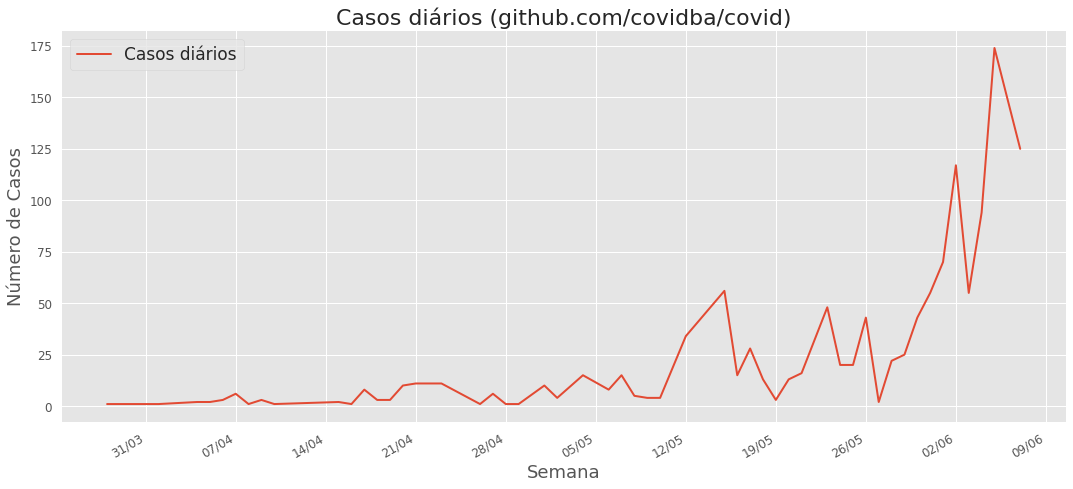

In [272]:
lista_de_cidades = ['Aiquara/BA', 'Apuarema/BA', 'Barra do Rocha/BA', 'Boa Nova/BA', 'Cravolândia/BA', 
                    'Dário Meira/BA', 'Ibirataia/BA', 'Ipiaú/BA', 'Iramaia/BA', 'Itagi/BA', 'Itagibá/BA',
                    'Jaguaquara/BA', 'Jequié/BA', 'Jitaúna/BA', 'Lafaiete Coutinho/BA', 'Lajedo do Tabocal/BA', 'Manoel Vitorino/BA', 'Maracás/BA',
                    'Nova Itarana/BA', 'Santa Inês/BA']

lista_de_cidades.remove('Ipiaú/BA')
lista_de_cidades.remove('Jequié/BA')

dfx = df.loc[df['city'].isin(lista_de_cidades), ['date', 'city', 'totalCases']]
dfx.columns = ['data', 'Cidade', 'Total de casos']

lista_de_dfx = []
for cidade in lista_de_cidades:
  lista_de_dfx.append(dfx.loc[df['city'].isin([cidade])])

lista_df = []
lista_de_cidades_sem_BA = []
for cidade in lista_de_cidades:
  lista_de_cidades_sem_BA.append(cidade[:-3])

for id, cidade in enumerate(lista_de_cidades_sem_BA):
  #df_ = pd.DataFrame({cidade: lista_de_dfx[id]['Total de casos']})
  df_ = pd.DataFrame({'Data': lista_de_dfx[id]['data'], cidade: lista_de_dfx[id]['Total de casos']})
  lista_df.append(df_)

#refazer lista com casos >= 50
lista_50 = []
for id, lista in enumerate(lista_df):
  lista_ = lista.loc[lista[lista_de_cidades_sem_BA[id]]>=0]
  if not lista_.empty:
    lista_.index = np.arange(len(lista_))
    lista_50.append(lista_)

for df_geral in lista_50:
  df_geral.set_index('Data', inplace=True)

df_geral = pd.concat(lista_50, axis=1)
df_geral['Casos diários'] = df_geral.sum(axis=1)
df_geral['Casos acumulativos'] = df_geral['Casos diários'].cumsum()

df_total = pd.DataFrame({"Casos diários": df_geral['Casos diários']})

fig, ax = plt.subplots(figsize=(18, 8))
df_total.plot(ax=ax, kind='line', lw=2)
 
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=17))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

#def adicionar_valores():
 # ax.annotate(int(df_total["Total"].max()), xy=(len(df_total["Total"])-1, df_total["Total"].max()), 
  #            xycoords='data', ha='left', fontsize=15, xytext=(0, 0), textcoords='offset points')
#adicionar_valores()

#ax.set_xlim([pd.Timestamp("2020-04-20"), lista_de_dfx[0]['data'].max()]) 
#ax.set_ylim([1, df_geral['Jequié'].max()+10000])
#ax.set_ylim([0, 60])
#ax.set_xlim([0, 30]) 
ax.set_title("Casos diários (%s)" % url_fonte, fontsize=22)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Semana', fontsize=18)
#ax.set_yscale('log')
ax.grid(True)

In [176]:
!pip install platypus-opt
!pip install pyswarms==1.1.0

from modelos import SIR, SEIR

#Start the model with population size
populacao = 250000
model = SEIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df_geral['Casos acumulativos']
#Give the number of days since the day of first case confirmed
x = range(1,len(df_geral['Casos acumulativos']) + 1)
model.fit(x = x, y = y)
#model.optimize=None
df_geral["Expectativa"] = model.predict(x)


2020-06-08 16:04:43,502 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.local_best:   0%|          |0/500/content/gdrive/My Drive/model/main/modelos.py:686: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=4.07
2020-06-08 16:06:26,096 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 4.066154900078681, best pos: [1.34913827 0.4081084  8.72281641 0.23185644 0.22520538]


/content/gdrive/My Drive/model/main/modelos.py:686: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


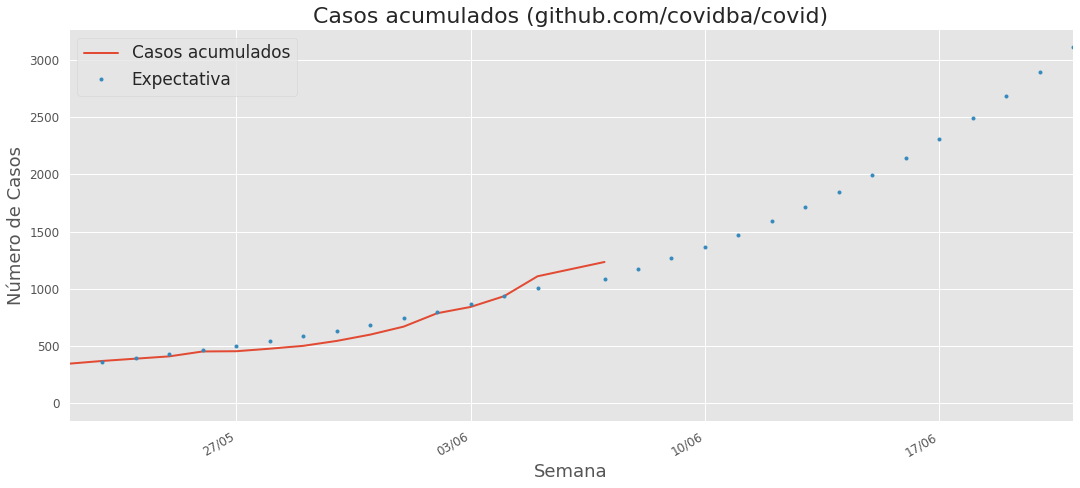

In [271]:
furtherCases = pd.DataFrame.from_dict({"Data":pd.date_range(start = df_geral.index.max()+timedelta(days=1) , end = df_geral.index.max()+timedelta(days=14))})
furtherCases.set_index('Data', inplace=True)

new_df = pd.concat([df_total, furtherCases])
#create the new series to be predicted
predictions = model.predict(new_df)
new_df = df_total.append(furtherCases)
new_df['Expectativa'] = predictions
new_df['Casos acumulados'] = df_geral['Casos acumulativos'] 

new_df = pd.DataFrame({"Casos acumulados": new_df['Casos acumulados'], "Expectativa": new_df['Expectativa']})

ls = ['-', '.']
fig, ax = plt.subplots(figsize=(18, 8))
new_df.plot(ax=ax, kind='line', lw=2, style=ls)

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=17))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

#def adicionar_valores():
 # ax.annotate(int(df_total["Total"].max()), xy=(len(df_total["Total"])-1, df_total["Total"].max()), 
  #            xycoords='data', ha='left', fontsize=15, xytext=(0, 0), textcoords='offset points')
#adicionar_valores()

#ax.set_xlim([pd.Timestamp("2020-04-20"), lista_de_dfx[0]['data'].max()]) 
ax.set_xlim([new_df.index.max()-timedelta(days=30), new_df.index.max()])
#ax.set_ylim([0, 60])
#ax.set_xlim([0, 30]) 
ax.set_title("Casos acumulados (%s)" % url_fonte, fontsize=22)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Semana', fontsize=18)
#ax.set_yscale('log')
ax.grid(True)

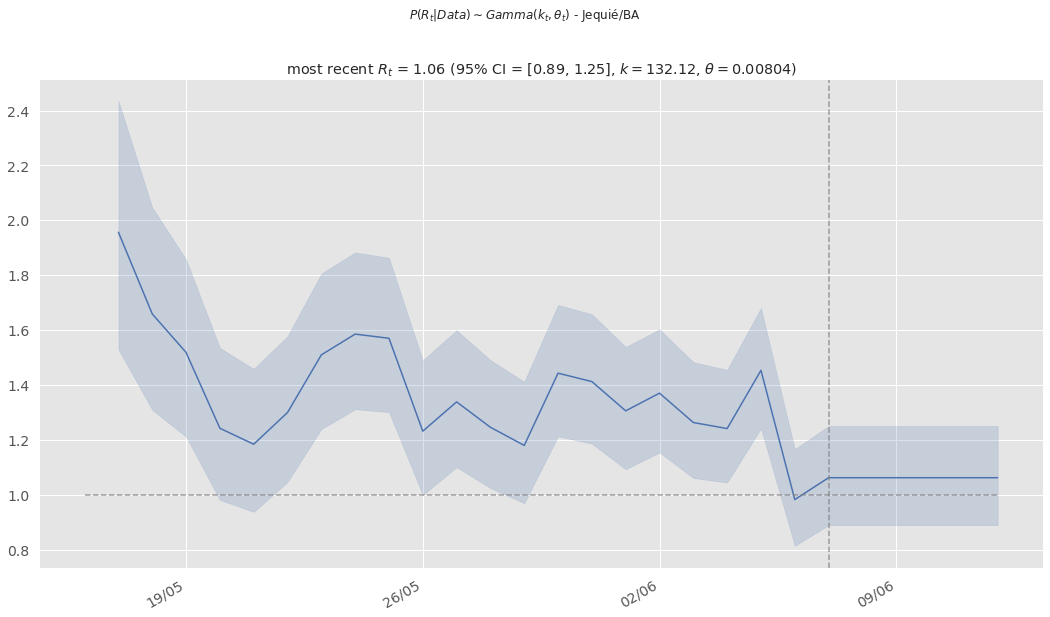

In [276]:
def run_Rt_estimation(incidence, prior_shape, prior_scale, mean_si, sd_si, t_max, window_width):
    
    si_pars = {'mean': mean_si, 'sd': sd_si}
    
    Rt = ReproductionNumber(incidence=incidence,
                            si_pars=si_pars,
                            prior_shape=prior_shape, 
                            prior_scale=prior_scale,
                            window_width=window_width
                           )
    
    Rt.compute_posterior_parameters()

    Rt_posterior_sample = Rt.sample_from_posterior(sample_size=N)
    Rt.compute_posterior_summaries(posterior_sample=Rt_posterior_sample, t_max=t_max)

    results = Rt
    
    return results

def plot_graph(posterior_summary, title=title):
  d = posterior_summary
  if d is None:
      txt = "You need to compute the summaries for the posterior distribution of Rt."
      raise ValueError(txt)
  if title is None:
      title = "R(t): time-varying reproduction number"
  plt.style.use('ggplot')
  fig, ax = plt.subplots(figsize=(18, 10))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

  plt.plot(d['end_dates'], d['Rt_mean'], color='b')
  plt.plot(d['end_dates'], [1] * len(d['Rt_mean']), color='gray', linestyle='dashed', alpha=0.75)
  plt.fill_between(d['end_dates'],
                    d['Rt_q0.975'],
                    d['Rt_q0.025'],
                    color='b', alpha=0.2)
  plt.title(title)
  plt.suptitle("$P(R_t | Data) \sim Gamma(k_t, \\theta_t)$ - Jequié/BA")
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  fig.autofmt_xdate()

  if 'estimation_type' in d.columns:
      plt.axvline(x=max(d[d['estimation_type'] == "fitted"]["end_dates"]),
                  color='gray', linestyle='dashed', alpha=0.75)
  plt.show()
  
N = 100_000
data['date'] = data['date'].astype('datetime64[ns]')
t_max = 5
window_width = 6

def get_incidence_data(cidade):

    incidence = df.loc[df['city'].isin([cidade]), ['date', 'newCases', 'totalCases']]
    incidence = incidence.set_index('date')
    
    incidence = (incidence.asfreq('d')
                 .assign(newCases=lambda x: x.newCases.fillna(0),
                         totalCases=lambda x: x.totalCases.fillna(method='ffill'))
                 .query('totalCases >= 50'))

    incidence = incidence.reset_index()
    incidence.columns = ['dates', 'incidence', 'totalCases']
    incidence = incidence.set_index('dates')
    
    return incidence[['incidence']]

brazil_incidence = get_incidence_data(cidade="Jequié/BA")
brazil_results = run_Rt_estimation(incidence=brazil_incidence,
                                   prior_shape=5.12, prior_scale=0.64,
                                   mean_si=7.5, sd_si=3.4,
                                   t_max=t_max, window_width=window_width)

last_known_day = brazil_results.posterior_summary.query('end_dates == "2020-06-07"')

most_recent_Rt = last_known_day['Rt_mean'].round(2).values[0]
upper = last_known_day['Rt_q0.975'].round(2).values[0]
lower = last_known_day['Rt_q0.025'].round(2).values[0]
brazil_posterior_shape = last_known_day['Rt_shape'].values[0]
brazil_posterior_scale = last_known_day['Rt_scale'].values[0]
title = f"most recent $R_t$ = {most_recent_Rt} (95% CI = [{lower}, {upper}], $k = {round(brazil_posterior_shape, 2)}$, $\\theta = {round(brazil_posterior_scale, 5)}$)"
plot_graph(brazil_results.posterior_summary, title=title)

## SOMENTE PRA BKP


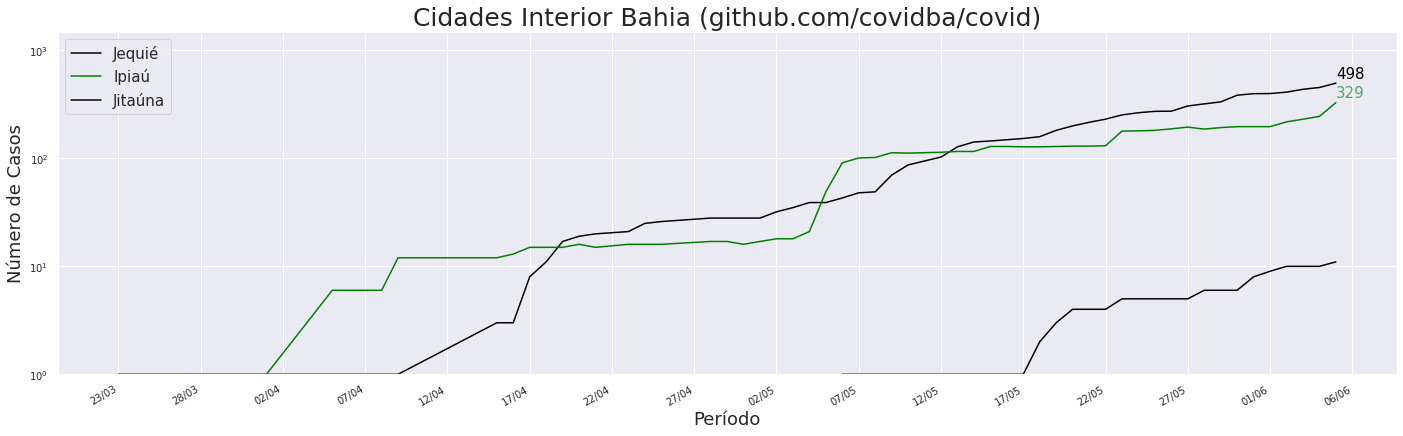

In [0]:
url_fonte = 'github.com/covidba/covid'

from matplotlib.dates import MO
import seaborn as sns
sns.set()

dfx = df.loc[df['Cidade'].isin(['Jequié/BA', 'Ipiaú/BA', 'Jitaúna/BA']), ['data', 'Cidade', 'Total de casos']]
jequie = (dfx.loc[df['Cidade'].isin(['Jequié/BA'])])
ipiau = (dfx.loc[df['Cidade'].isin(['Ipiaú/BA'])])
jitauna = (dfx.loc[df['Cidade'].isin(['Jitaúna/BA'])])

dic_jitauna = {'Data': jitauna['data'], 'Jitaúna': jitauna['Total de casos']}   
dic_jequie = {'Data': jequie['data'], 'Jequié': jequie['Total de casos']}       
dic_ipiau = {'Data': ipiau['data'], 'Ipiaú': ipiau['Total de casos']}
df2 = pd.DataFrame(dic_jequie)
df3 = pd.DataFrame(dic_ipiau)
df4 = pd.DataFrame(dic_jitauna)
df2.set_index('Data', inplace=True)
df3.set_index('Data', inplace=True)
df4.set_index('Data', inplace=True)

#df_geral = pd.concat([ipiau, jequie, jitauna], axis=1)
#print(df_geral)

df_geral = pd.concat([df2, df3, df4], axis=1)
df_geral = df_geral.fillna(method='ffill')

colors = ['black', 'green']
fig, ax = plt.subplots(figsize=(24,7))
df_geral.plot(ax=ax, color=colors, kind='line')
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def adicionar_valores(caso, color, x=0, y=5):
  ax.annotate(int(df_geral[caso].max()), xy=(dic_jequie['Data'].max(), df_geral[caso].max()), 
              xycoords='data', ha='left', fontsize=15, color=color,
              xytext=(x, y), textcoords='offset points')
 
adicionar_valores('Jequié', 'black')
adicionar_valores('Ipiaú', 'g')
 
ax.set_ylim([1, df_geral['Jequié'].max()+1000])
ax.set_title("Cidades Interior Bahia (%s)" % url_fonte, fontsize=25)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.set_yscale('log')
ax.grid(True)

